# Lab 3

### Simon Jasansky

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv("data/caravan.csv")
df_test = pd.read_csv("data/caravanTest.csv")

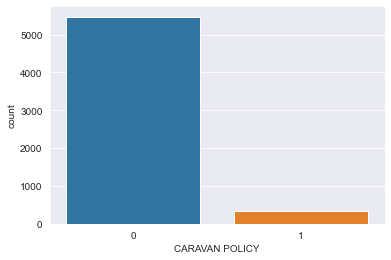

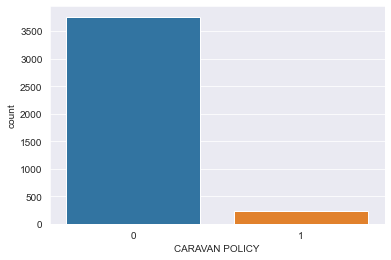

Positive instances train set: 348
Negative instances train set: 5474
Positive instances: test set 238
Negative instances: test set3762


In [2]:
# data exploration
sns.countplot(x = df["CARAVAN POLICY"])
plt.show()
sns.countplot(x = df_test["CARAVAN POLICY"])
plt.show()

print("Positive instances train set: " + str(df["CARAVAN POLICY"].sum()) + "")
print("Negative instances train set: " + str(len(df.loc[df["CARAVAN POLICY"] == 0])))

print("Positive instances: test set " + str(df_test["CARAVAN POLICY"].sum()) + "")
print("Negative instances: test set" + str(len(df_test.loc[df_test["CARAVAN POLICY"] == 0])))

#display(df.describe().T)
#display(df_test.describe().T)

Not very balanced dataset

## Assignment 1
### Describe the actual or potential customers and possibly explain why these customers buy a caravan policy.

1.1:
The purpose of assignment 1 is to give a clear insight to why customers have a caravan insurance
policy and how these customers are different from other customers. Descriptions can be based on
regression equations, decision trees, linguistic descriptions, graphical representations or any other
form. The descriptions and accompanying interpretation must be comprehensible, useful and
actionable for a marketing professional with no prior knowledge of data mining.

1.2:
Compare some different techniques and/or settings of parameters to see how well they perform
on this problem. For this comparison you may assume some basic knowledge about data mining
with the reader. In Appendix B details are provided how to use scikit-learn For feature selectio

In [3]:
# Approaches:
# logistic regression with lasso regularization (good explainability)
# decision trees or decision rules, output the paths that lead to buying caravan insurance
# KNN

# graphical representations: Bar-chart with positive and negative contribution derived from logistic regression
# Do PCA

# Apply RFECV

In [4]:
# Remove features with low variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.98 * (1 - .98)))

print(df.shape)
print(df_test.shape)

# drop variables from both train and test data
sel.fit(df)
sel_cols = sel.get_feature_names_out()
df = df[sel_cols]
df_test = df_test[sel_cols]

print(df.shape)
print(df_test.shape)

(5822, 86)
(4000, 86)
(5822, 73)
(4000, 73)


In [5]:
# Normalize data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df)
d = scaler.transform(df)
scaled_df = pd.DataFrame(d, columns=df.columns)
d_test = scaler.transform(df_test)
scaled_df_test = pd.DataFrame(d_test, columns=df_test.columns)

In [6]:
# define X and y for training and testing datasets
X_names = [x for x in df.columns if x != "CARAVAN POLICY"]
X = scaled_df[X_names]
y = scaled_df["CARAVAN POLICY"]
X_test = scaled_df_test[X_names]
y_test = scaled_df_test["CARAVAN POLICY"]

In [7]:
# define X and y for training and testing datasets not scaled!
X_ns = df[X_names]
y_ns = df["CARAVAN POLICY"]
X_ns_test = scaled_df_test[X_names]
y_ns_test = scaled_df_test["CARAVAN POLICY"]

#### 1. Approach:
Very simple approach: split customers into two groups, one that bought insurance and one that did not. Compare the differences in the means of the two groups.

Index(['Rented house', 'Home owners', 'Purchasing power class',
       'Contribution private third party insurance',
       'Contribution car policies'],
      dtype='object')


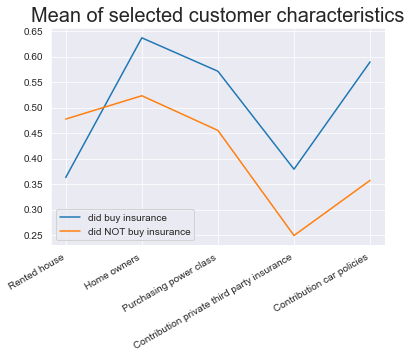

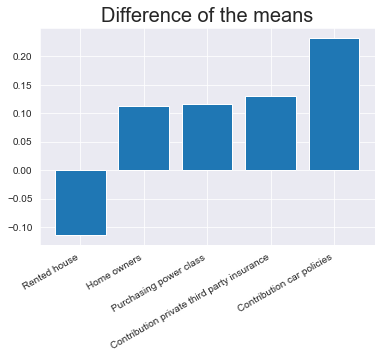

In [8]:
pos_df = scaled_df[scaled_df["CARAVAN POLICY"] == 1]
neg_df = scaled_df[scaled_df["CARAVAN POLICY"] == 0]

pos_df = pos_df.drop("CARAVAN POLICY", axis = 1)
neg_df = neg_df.drop("CARAVAN POLICY", axis = 1)

diff_df = pos_df.describe().T - neg_df.describe().T
# I chose difference to be larger than 0.1 (arbitrary)
top_diff = diff_df[abs(diff_df["mean"]) > 0.1]
top_diff_vars = top_diff["mean"].index

print(top_diff_vars)

# lineplot
plt.plot(top_diff_vars,
         pos_df.describe()[top_diff_vars].T["mean"])
plt.plot(top_diff_vars,
         neg_df.describe()[top_diff_vars].T["mean"])
plt.xticks(rotation = 30, ha = "right")
plt.title("Mean of selected customer characteristics", size = 20)
plt.legend(["did buy insurance", "did NOT buy insurance"])
plt.show()

# barplot
plt.bar(top_diff_vars, top_diff["mean"])
plt.xticks(rotation = 30, ha = "right")
plt.title("Difference of the means", size = 20)
plt.show()

Interpretation:
As seen in the graphs above, the two customer groups show the biggest differences in their respective means for the variables 'Rented house', 'Home owners', 'Purchasing power class','Contribution private third party insurance', and 'Contribution car policies'. For the first two variables, it means that customers are less likely to buy caravan insurance if they come from a neighborhood that has more rented housing, and more likely to buy one if the neighborhood has more homeowners. Further, a higher purchasing power class in the neighborhood and having a high coverage in private third party insurance in the zip code area also makes it also more likely to buy caravan insurance. The most significant difference, however, seems to be in the average coverage of car policies in the customer's neighborhood: customers purchasing caravan insurance seem to have much higher car policy insurance coverage than those who do not purchase caravan insurance.

#### 2. Approach:
Find k best variables using SelectKBest with three different statistical functions

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

important_vars = list()
scores = list()

for classifier in (chi2, f_classif, mutual_info_classif):
    selector = SelectKBest(classifier, k = 5).fit(X, y)
    cols = selector.get_support(indices=True)
    important_vars.append(selector.feature_names_in_[cols])
    scores.append(selector.scores_[cols])

intersection = set(important_vars[0]) & set(important_vars[1]) & set(important_vars[2])
print("The variables that were selected as important variables in all of the three methods are: " + str(intersection))

The variables that were selected as important variables in all of the three methods are: {'Contribution car policies'}


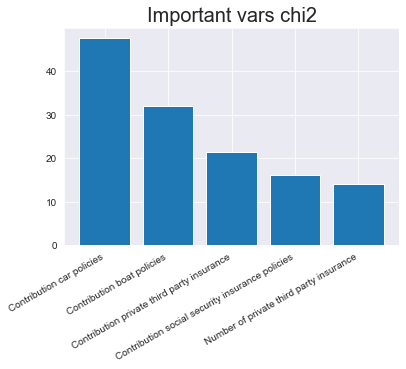

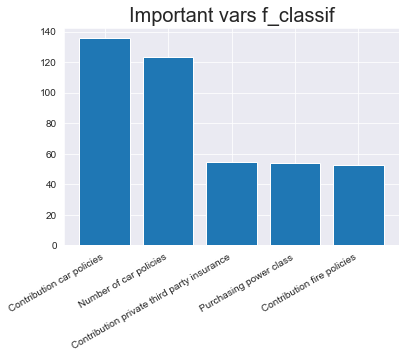

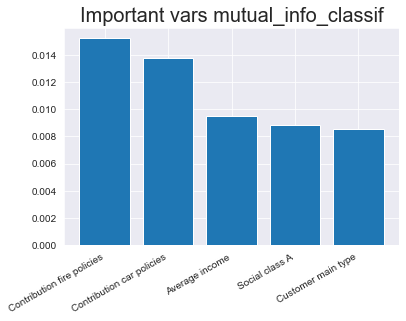

In [10]:
# plot the important variables selected by the three statistical tests
for i, classifier in enumerate(["chi2", "f_classif", "mutual_info_classif"]):
    kbest_df = pd.DataFrame({"vars": important_vars[i],
                                "scores": scores[i]})
    kbest_df = kbest_df.sort_values("scores", ascending=False)
    plt.bar(kbest_df["vars"], kbest_df["scores"])
    plt.xticks(rotation = 30, ha = "right")
    plt.title("Important vars " + classifier, size = 20)
    plt.show()

Again, Contribution car policies is the most important predictor in all three cases.

#### 3. Approach:
Fit the variables identified above to models, in order to get the model coefficients. See if the order of importance changes

LogisticRegression() SelectKBest(k=5, score_func=<function chi2 at 0x000001948A579040>)
Training data: 


array([[   0,  348],
       [   0, 5474]], dtype=int64)

0.9402267262109241
Test data: 


array([[   0,  238],
       [   0, 3762]], dtype=int64)

0.9405


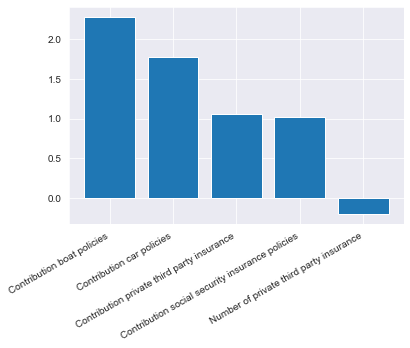

LogisticRegression() SelectKBest(k=5)
Training data: 


array([[   0,  348],
       [   0, 5474]], dtype=int64)

0.9402267262109241
Test data: 


array([[   0,  238],
       [   0, 3762]], dtype=int64)

0.9405


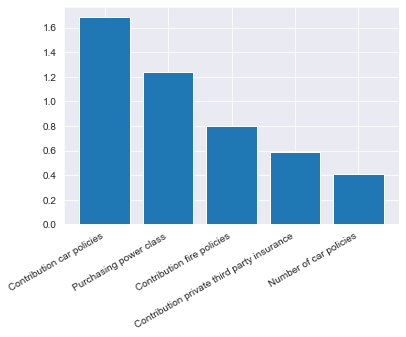

LogisticRegression() SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x000001948A934040>)
Training data: 


array([[   0,  348],
       [   0, 5474]], dtype=int64)

0.9402267262109241
Test data: 


array([[   0,  238],
       [   0, 3762]], dtype=int64)

0.9405


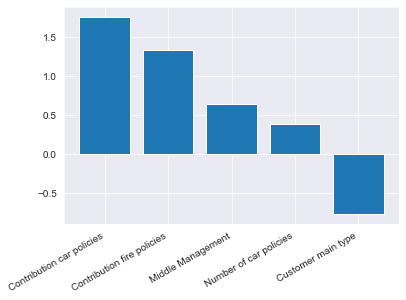

DecisionTreeClassifier() SelectKBest(k=5, score_func=<function chi2 at 0x000001948A579040>)
Training data: 


array([[  12,  336],
       [   2, 5472]], dtype=int64)

0.941944349020955
Test data: 


array([[   0,  238],
       [  10, 3752]], dtype=int64)

0.938


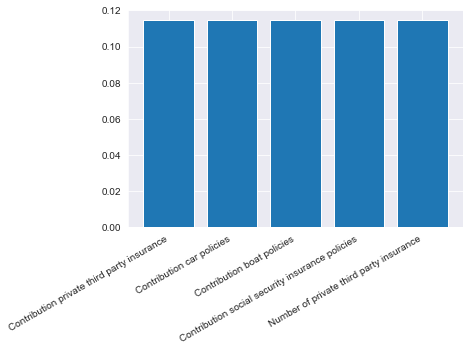

DecisionTreeClassifier() SelectKBest(k=5)
Training data: 


array([[   8,  340],
       [   0, 5474]], dtype=int64)

0.9416008244589488
Test data: 


array([[   2,  236],
       [   4, 3758]], dtype=int64)

0.94


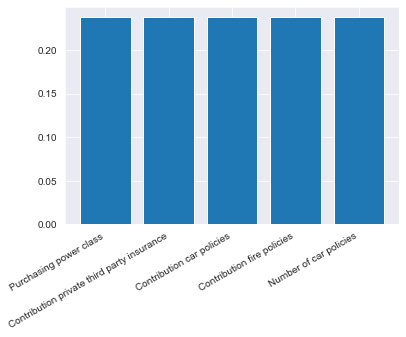

DecisionTreeClassifier() SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x000001948A934040>)
Training data: 


array([[  92,  256],
       [   8, 5466]], dtype=int64)

0.9546547578151838
Test data: 


array([[  20,  218],
       [  85, 3677]], dtype=int64)

0.92425


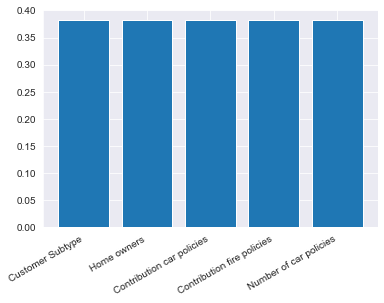

In [11]:
# write code above as a pipeline, so that it can then be applied with all different feature selection methods, and with all different ML models
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# create pipeline
k = 5
classifiers = [LogisticRegression(), DecisionTreeClassifier()]
selectors = [SelectKBest(chi2, k = k),
             SelectKBest(f_classif, k = k),
             SelectKBest(mutual_info_classif, k = k)]

for i, classifier in enumerate(classifiers):
    for selector in selectors:

        print(classifier, selector)
        pipeClassifier = make_pipeline(selector, classifier)

        # fit the training data
        pipeClassifier.fit(X, y)

        y_pred = pipeClassifier.predict(X)
        y_pred_test = pipeClassifier.predict(X_test)

        # get features used
        vars = pipeClassifier.named_steps.selectkbest.get_feature_names_out()

        # get the scores/importances of the features
        if i == 0:
            coef = pipeClassifier.named_steps.logisticregression.coef_
        if i == 1:
            coef = pipeClassifier.named_steps.decisiontreeclassifier.feature_importances_

        print("Training data: ")
        display(confusion_matrix(y, y_pred, labels= [1,0]))
        print(accuracy_score(y, y_pred))

        print("Test data: ")
        display(confusion_matrix(y_test, y_pred_test, labels= [1,0]))
        print(accuracy_score(y_test, y_pred_test))

        kbest_df = pd.DataFrame({"vars": vars,
                                 "scores": coef[0]})
        kbest_df = kbest_df.sort_values("scores", ascending=False)
        plt.bar(kbest_df["vars"], kbest_df["scores"])
        plt.xticks(rotation = 30, ha = "right")
        plt.show()

Looking at the confusion matrices, the models do not seem to be useful at all. Thus, the important variables from this 3. approach should be disregarded.

#### 4. Approach:
Find best predictors using Recursive Feature Elimination with the classification models: Logistic Regression, Decision Trees, Naive Bayes, Decision Trees.

LogisticRegression(max_iter=100000)


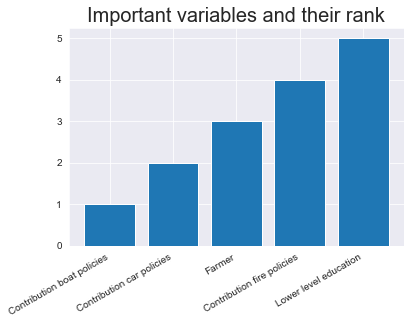

DecisionTreeClassifier()


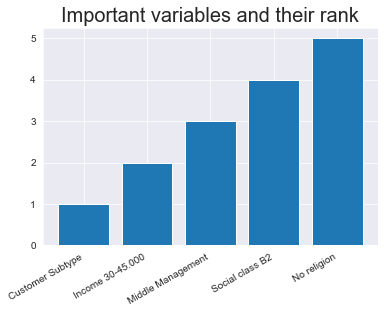

SVC(kernel='linear', max_iter=100000)


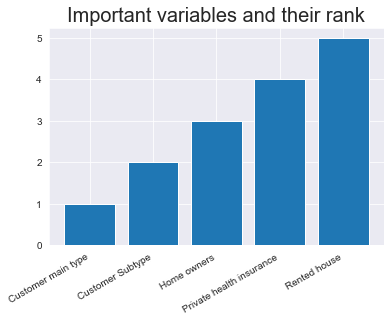

In [12]:
# Do recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.svm import SVC


classifiers = (LogisticRegression(max_iter=100000),
               DecisionTreeClassifier(),
               SVC(kernel="linear", max_iter=100000))
n_features_to_select = 1

for classifier in classifiers:
    print(classifier)
    rfe = RFE(estimator=classifier,
              n_features_to_select=n_features_to_select,
              step=1)

    rfe.fit(X, y)
    # construct dataframe with top features only
    kbest_df = pd.DataFrame({"vars": X.columns,
                             "scores": rfe.ranking_})
    kbest_df = kbest_df.sort_values("scores", ascending=True)
    kbest_df = kbest_df.nsmallest(5, "scores")
    plt.bar(kbest_df["vars"], kbest_df["scores"])
    plt.xticks(rotation = 30, ha = "right")
    plt.title("Important variables and their rank", size = 20)
    plt.show()

In Conclusion, the 1. approach seems to be perform relatively well, as it is backed up by the outcome of the 2. approach and partially of the 4. approach. approach, but much simpler to explain to person not familiar with data mining. Thus, the first approach should be chosen for that task. This also makes it easy for a marketing professional to deduct policies, as they can simply focus on the five features, assess how far a potential customer deviates from the means in the respective groups, and then assess how likely it is that the person buys caravan insurance.

## Assignment 2
### Select customers from a test file to send information to. The file with those customers will be provided on the day of lab’s deadline.

The purpose of assignment 2 is to find a set of 800 customers from the test set that contains the
most caravan policy owners. Use your most accurate model to select the 800 most likely policy
owners.

## 2.1. Gradient Boosting with Balancing

In [13]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import precision_score

classifier = BalancedBaggingClassifier()
selector = SelectKBest(chi2, k = 70)

pipeClassifier = make_pipeline(selector, classifier)
pipeClassifier.fit(X, y)

y_pred = pipeClassifier.predict(X)
y_pred_test = pipeClassifier.predict(X_test)

print("Training data: ")
display(confusion_matrix(y, y_pred, labels=[1,0]))
print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred))


print("Test data: ")
display(confusion_matrix(y_test, y_pred_test, labels=[1,0]))
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y, y_pred))

Training data: 


array([[ 327,   21],
       [ 889, 4585]], dtype=int64)

0.8436963242871865
0.2689144736842105
Test data: 


array([[  98,  140],
       [ 739, 3023]], dtype=int64)

0.78025
0.2689144736842105


## 2.2. Random Forest with Balancing with choosing k best predictors

In [14]:
# Random Forest with Balancing with choosing k best predictors
from imblearn.ensemble import BalancedRandomForestClassifier

classifier = BalancedRandomForestClassifier()
selector = SelectKBest(chi2, k = 10)

pipeClassifier = make_pipeline(selector, classifier)
pipeClassifier.fit(X, y)

y_pred = pipeClassifier.predict(X)
y_pred_test = pipeClassifier.predict(X_test)

print("Training data: ")
display(confusion_matrix(y, y_pred, labels=[1,0]))
print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred))

print("Test data: ")
display(confusion_matrix(y_test, y_pred_test, labels=[1,0]))
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y, y_pred))

Training data: 


array([[ 346,    2],
       [1738, 3736]], dtype=int64)

0.7011336310546205
0.16602687140115163
Test data: 


array([[ 157,   81],
       [1263, 2499]], dtype=int64)

0.664
0.16602687140115163


## 2.3. Random Forest with Balancing without choosing k best predictors

In [15]:
rf = BalancedRandomForestClassifier()
rf.fit(X,y)

y_pred = rf.predict(X)
y_pred_test = rf.predict(X_test)

print("Training data: ")
display(confusion_matrix(y, y_pred, labels=[1,0]))
print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred))

print("Test data: ")
display(confusion_matrix(y_test, y_pred_test, labels=[1,0]))
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y, y_pred))

Training data: 


array([[ 348,    0],
       [1534, 3940]], dtype=int64)

0.7365166609412573
0.1849096705632306
Test data: 


array([[ 147,   91],
       [1199, 2563]], dtype=int64)

0.6775
0.1849096705632306


## 2.3.1 Random forest hyperparameter tuning
As Random forest with balancing has performed in terms of number of true positives, it will be subject to hyperparameter tuning using grid search.

In [16]:
# Parameters:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 120, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 5, 10, 20, 60]
# Maximum number of levels in tree
max_depth = [2, 4, 6]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
replacement = [True, False]
oob_score = [True, False]
class_weight = [None, {1:10}]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'replacement': replacement,
              'oob_score': oob_score,
              'class_weight': class_weight}
print(param_grid)

{'n_estimators': [80, 120], 'max_features': ['auto', 5, 10, 20, 60], 'max_depth': [2, 4, 6], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False], 'replacement': [True, False], 'oob_score': [True, False], 'class_weight': [None, {1: 10}]}


In [17]:
from sklearn.model_selection import GridSearchCV
rf_hpt = BalancedRandomForestClassifier()
rf_hpt_Grid = GridSearchCV(estimator = rf_hpt,
                           param_grid = param_grid,
                           cv = 2, verbose=2,
                           n_jobs = -1)

In [18]:
%%capture
rf_hpt_Grid.fit(X, y)

In [19]:
rf_hpt_Grid.best_params_

{'bootstrap': True,
 'class_weight': None,
 'max_depth': 2,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 80,
 'oob_score': False,
 'replacement': False}

In [20]:
# 2. round of hyperparameter tuning (I did not overwrite above for documentation purposes)

# Number of trees in random forest
n_estimators = [80]
# Number of features to consider at every split
max_features = [4, 5, 6, 7, 8]
# Maximum number of levels in tree
max_depth = [2, 4]
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [80], 'max_features': [4, 5, 6, 7, 8], 'max_depth': [2, 4], 'min_samples_split': [5], 'min_samples_leaf': [2], 'bootstrap': [False]}


In [21]:
%%capture
rf_hpt_Grid = GridSearchCV(estimator = rf_hpt,
                           param_grid = param_grid,
                           cv = 2, verbose=2,
                           n_jobs = -1)

rf_hpt_Grid.fit(X, y)

In [22]:
rf_hpt_Grid.best_params_

{'bootstrap': False,
 'max_depth': 2,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 80}

## 2.3.2: Final model

In [23]:
y_pred = rf_hpt_Grid.predict(X)
y_pred_test = rf_hpt_Grid.predict(X_test)

print("Training data: ")
display(confusion_matrix(y, y_pred, labels=[1,0]))
print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred))

print("Test data: ")
display(confusion_matrix(y_test, y_pred_test, labels=[1,0]))
print(accuracy_score(y_test, y_pred_test))
print(precision_score(y, y_pred))

Training data: 


array([[ 246,  102],
       [1645, 3829]], dtype=int64)

0.6999312950875988
0.13008989952406133
Test data: 


array([[ 147,   91],
       [1150, 2612]], dtype=int64)

0.68975
0.13008989952406133
